In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from discoutils.thesaurus_loader import Vectors as vv

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [2]:
def _ws353():
    return pd.read_csv('../thesisgenerator/similarity-data/wordsim353/combined.csv',
                       names=['w1', 'w2', 'sim'])

def _mc():
    return pd.read_csv('../thesisgenerator/similarity-data/miller-charles.txt',
                       names=['w1', 'w2', 'sim'], sep='\t')

def _rg():
    return pd.read_csv('../thesisgenerator/similarity-data/rub-gooden.txt',
                       names=['w1', 'w2', 'sim'], sep='\t')

def _men():
    df = pd.read_csv('../thesisgenerator/similarity-data/MEN/MEN_dataset_lemma_form_full',
                       names=['w1', 'w2', 'sim'], sep=' ')
    def _convert_tag(word):
        return '%s/%s'%(word[:-2], word[-1].upper())
    df.w1 = df.w1.map(_convert_tag)
    df.w2 = df.w2.map(_convert_tag)
    return df

def datasets():
    yield 'ws353', _ws353()
#     yield 'mc', _mc()
#     yield 'rg', _rg()
    yield 'men', _men()

In [3]:
def intrinsic_eval(vectors, df, noise=0):
    v = vv.from_tsv(vectors, noise=noise)
    # v = vv.from_tsv('../FeatureExtractionToolkit/exp10-13-composed-ngrams/AN_NN_gigaw-100_Right.events.filtered.strings')
    def get_vector_for(word):
        vectors = []
        if word[-2] == '/':
            # pos tag is there already, let's just do it
            if word in v:
                vectors.append(v.get_vector(word))
        else:
            # what could the pos tag be?
            for pos in 'JNV':
                candidate = '%s/%s'%(word.lower(), pos)
                if candidate in v:
                    vectors.append(v.get_vector(candidate))
        if len(vectors) > 1:
            pass
#             print('multiple vectors for', word, len(vectors))
        return vectors

    model_sims, human_sims = [], []
    for w1, w2, human in zip(df.w1, df.w2, df.sim):
        v1, v2 = get_vector_for(w1), get_vector_for(w2)
        if v1 and v2:
            model_sims.append(cosine_similarity(v1[0], v2[0])[0][0])
            human_sims.append(human)

#     print(len(model_sims), len(human_sims))
    return spearmanr(model_sims, human_sims)[0] # rho, pval 

In [17]:
paths = ['../FeatureExtractionToolkit/word2vec_vectors/word2vec-gigaw-100perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-15perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-50perc.unigr.strings.rep0',
        '../FeatureExtractionToolkit/word2vec_vectors/word2vec-wiki-100perc.unigr.strings.rep0']
names = ['w2v-giga-100', 'w2v-wiki-15', 'w2v-wiki-50', 'w2v-wiki-100']

data = []

for dname, df in datasets():
    for vname, path in zip(names, paths):
        print(dname, vname)
        for noise in np.arange(.2, 2.1, .2): 
            res = intrinsic_eval(path, df, noise)
            data.append((vname, dname, noise, res))

ws353 w2v-giga-100
ws353 w2v-wiki-15
ws353 w2v-wiki-50
ws353 w2v-wiki-100
men w2v-giga-100
men w2v-wiki-15
men w2v-wiki-50
men w2v-wiki-100


In [18]:
df = pd.DataFrame(data, columns=['vect', 'test', 'noise', 'corr'])

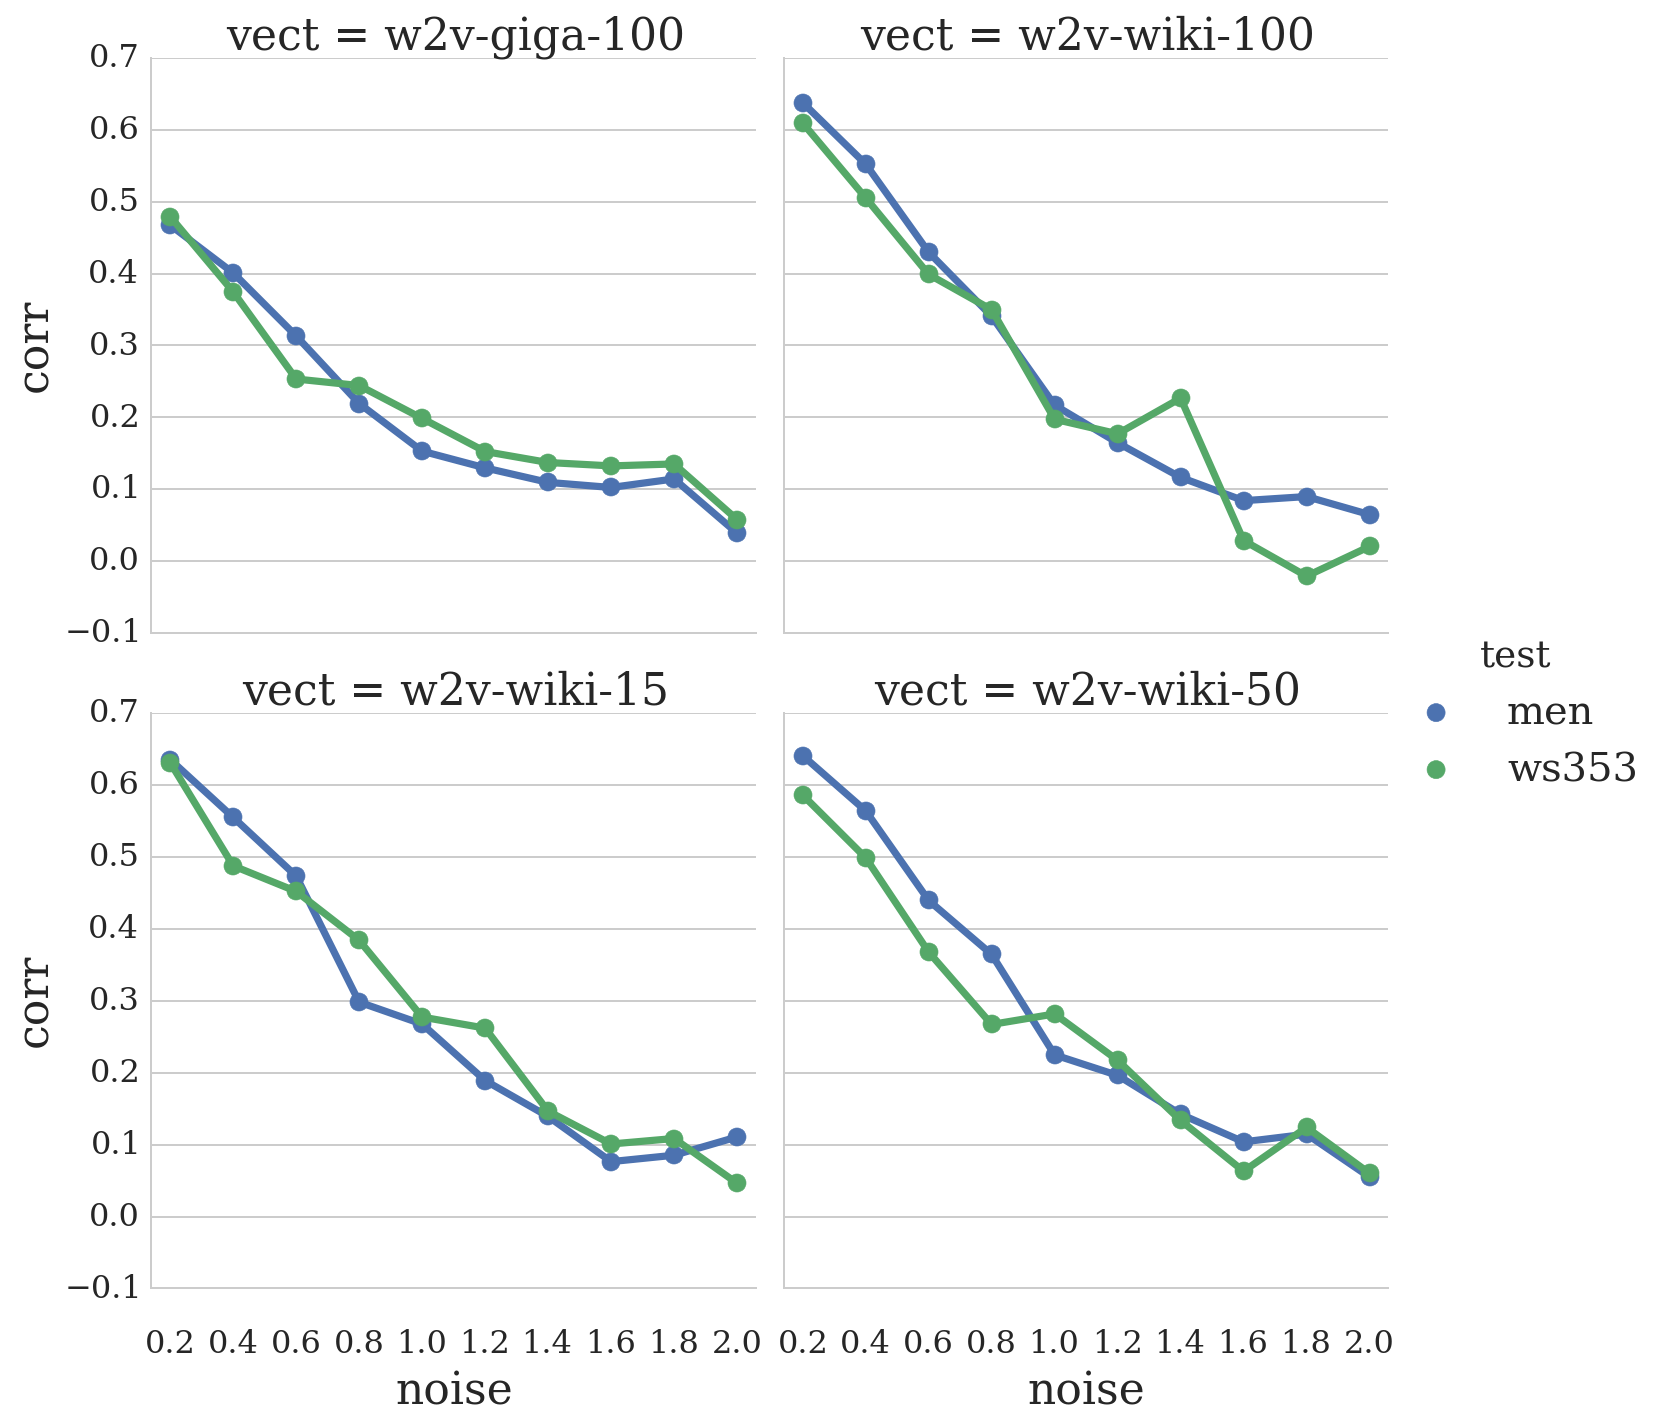

In [20]:
sns.factorplot(x='noise', col='vect', hue='test', y='corr', col_wrap=2,
               data=df, kind='point', x_order=sorted(df.noise.unique()));
plt.savefig('plot-intrinsic-eval.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

# State-of-the-art
Bruni, Tran, Baroni (multimodal dist semantics):
 - ws: 0.7
 - men: 0.77
 
Measured vector quality decreases nicely, but cannot tell between `wiki-15` and `wiki-100`. This may be because this is a relaxed test, where OOV items are not looked at. `wiki-15` will have lower coverage of types, so if it scored 0 for each OOV item it would probably have a lower score. 
 - Do people use the strict version?
 - What do I do with multiple possible POS tags per word for `ws353` data?

